#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [7]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [8]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')

In [9]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [10]:
data01_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


In [11]:
data01_train.drop('subject', axis=1, inplace=True)
data01_test.drop('subject', axis=1, inplace=True)

In [12]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [13]:
data01_train.shape

(5881, 562)

In [14]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [15]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [16]:
data01_train.isna().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(tBodyGyroJerkMean,gravityMean)",0
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 단변량분석 :숫자형, 범주형 변수에 맞게 데이터를 탐색하며 비즈니스적 의미를 파악합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [17]:
# 함수만들기
def categori_num(data, var) :
    t1 = data[var].value_counts()
    t2 = data[var].value_counts(normalize = True)
    t3 = pd.concat([t1, t2], axis = 1)
    t3.columns = ['count','ratio']
    display(t3)

    # y값 내림차순 정렬을 위해 카운트 데이터 정리
    count_data = t1.reset_index()
    count_data.columns = [var, 'count']
    count_data = count_data.sort_values(by='count', ascending=False)


    sns.countplot(x = var, data = data , order=count_data[var])
    plt.xticks(rotation=45)
    plt.show()

,count,ratio
Activity,,
LAYING,1115,0.189594
STANDING,1087,0.184833
SITTING,1032,0.175480
WALKING,998,0.169699
WALKING_UPSTAIRS,858,0.145894
WALKING_DOWNSTAIRS,791,0.134501


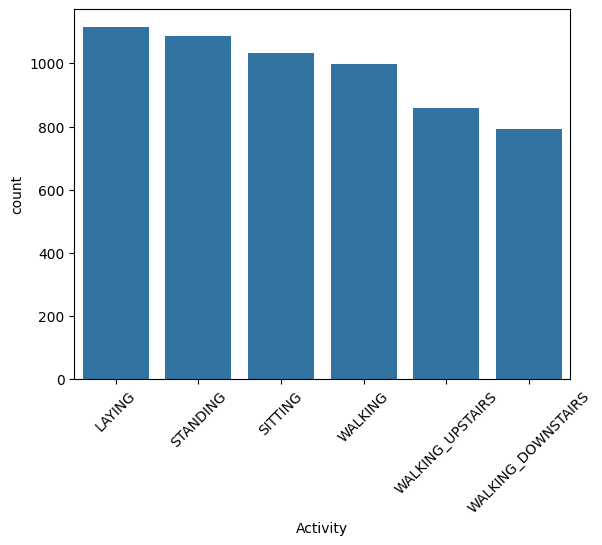

In [18]:
target = 'Activity'  # 다중분류

data01_train[target].head()
categori_num(data01_train, target)  # 정적 , 동적 데이터 수 살짝 차이남

### (3) 센서 그룹 데이터: features (삭제)

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수
        

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [19]:
# x, y로 나누고
x = data01_train.drop(target, axis=1)
y = data01_train.loc[:,target]
x.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758


In [40]:
# train과 validation 분할 수행
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=1)

#### 2) 모델링

In [41]:
# 선언하기
model = RandomForestClassifier(random_state = 1)

# 학습하기
model.fit(x_train,y_train)

# 예측하기
y_pred = model.predict(x_val)

# 평가하기
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9770603228547153
[[220   0   0   0   1   1]
 [  0 191   7   0   0   0]
 [  0   7 228   0   0   0]
 [  0   0   0 186   3   3]
 [  0   0   0   1 153   2]
 [  0   0   0   1   1 172]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       222
           SITTING       0.96      0.96      0.96       198
          STANDING       0.97      0.97      0.97       235
           WALKING       0.99      0.97      0.98       192
WALKING_DOWNSTAIRS       0.97      0.98      0.97       156
  WALKING_UPSTAIRS       0.97      0.99      0.98       174

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



#### 3) 변수 중요도 추출

- 결정 트리 계열 모델에서 특성 중요도를 계산하는 방법은 각 특성이 목표(target) 값들을 얼마나 잘 분리하는지를 기준으로 한다.

In [45]:
importance  =  plot_feature_importance(model.feature_importances_ , x_train.columns, result_only = True, topn = -5)
importance  # random_state , test_size 똑같이 주면 같은 변수 중요도 추출할 수 있다.

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.039942
1,tGravityAcc-min()-X,0.033346
2,tGravityAcc-energy()-X,0.028896
3,tGravityAcc-mean()-X,0.027753
4,tGravityAcc-min()-Y,0.024392
...,...,...
551,tBodyAccJerk-mean()-X,0.000096
552,fBodyBodyGyroJerkMag-sma(),0.000095
553,tBodyAcc-mad()-Y,0.000092
554,fBodyBodyAccJerkMag-entropy(),0.000091


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [43]:
n = 5  # 상위 n개만 분석

# 상위 n개 중요도
importance_upperfeature_list = importance['feature_name'].head(n).tolist()  # 피처 이름만 추출
importance_upperfeature_list

['angle(X,gravityMean)',
 'tGravityAcc-min()-X',
 'tGravityAcc-energy()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-Y']

In [46]:
def eda(feature, num):
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    sns.kdeplot(data=data01_train, x=feature[num], hue=target, fill=True)
    plt.title(f'{feature[num]} KDE plot')

    plt.subplot(1,3,2)
    sns.boxplot(data=data01_train, x=target, y=feature[num])
    plt.title(f'{feature[num]} Box plot')
    plt.xticks(rotation=15)

    plt.subplot(1,3,3)
    sns.barplot(data=data01_train, x=target, y=feature[num])
    plt.title(f'{feature[num]} Mean')
    plt.xticks(rotation=15)

    plt.tight_layout()
    plt.show()

#### 2) 상위 5개 변수에 대한 분석

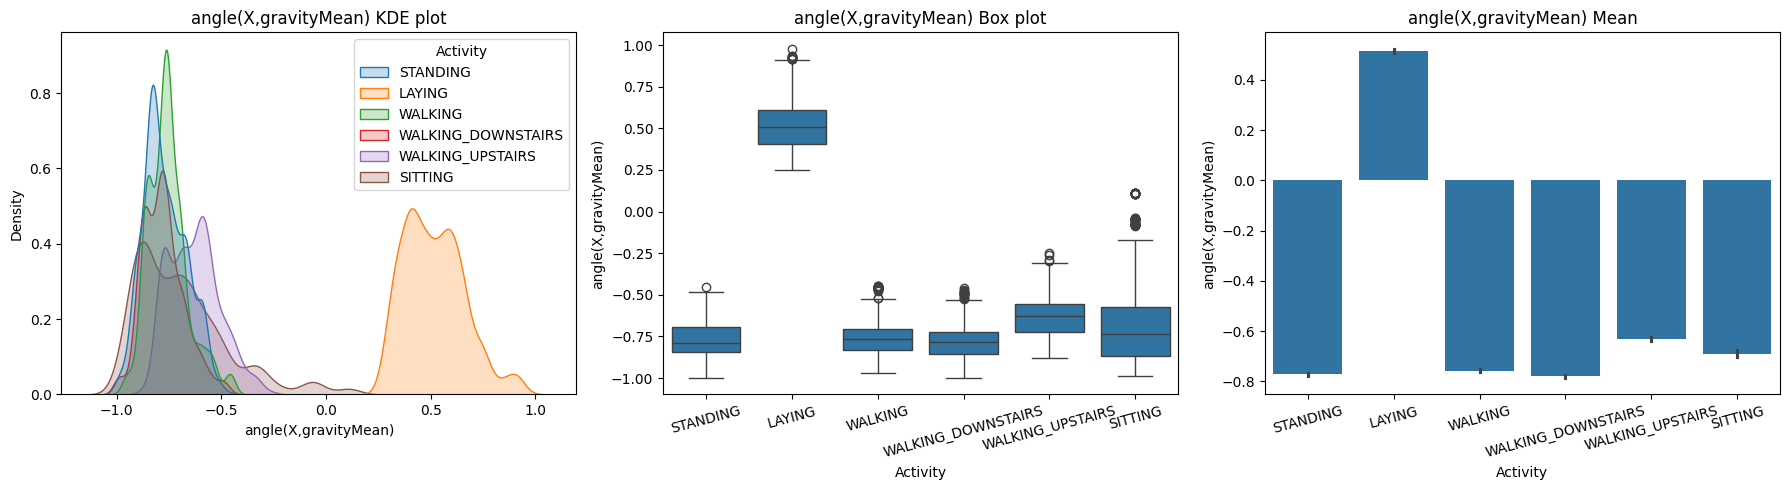

In [48]:
# 1. angle(X,gravityMean)
eda(importance_upperfeature_list, 0)

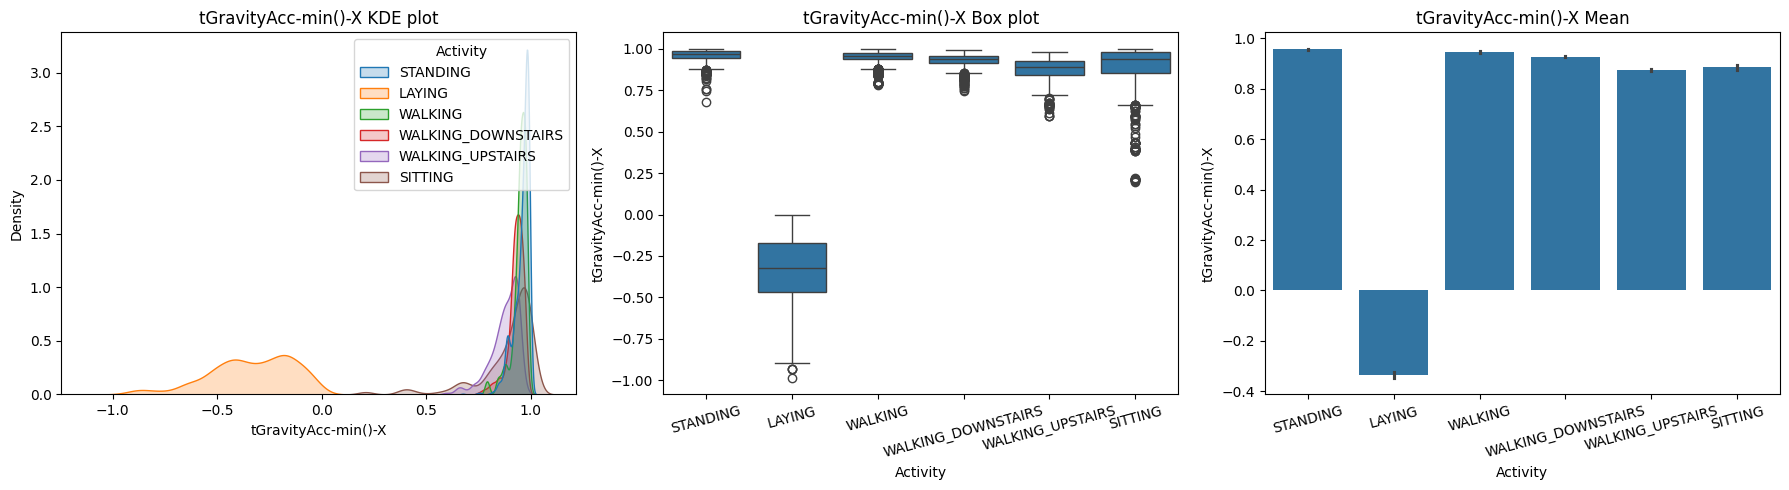

In [49]:
# 2. tGravityAcc-min()-X
eda(importance_upperfeature_list, 1)

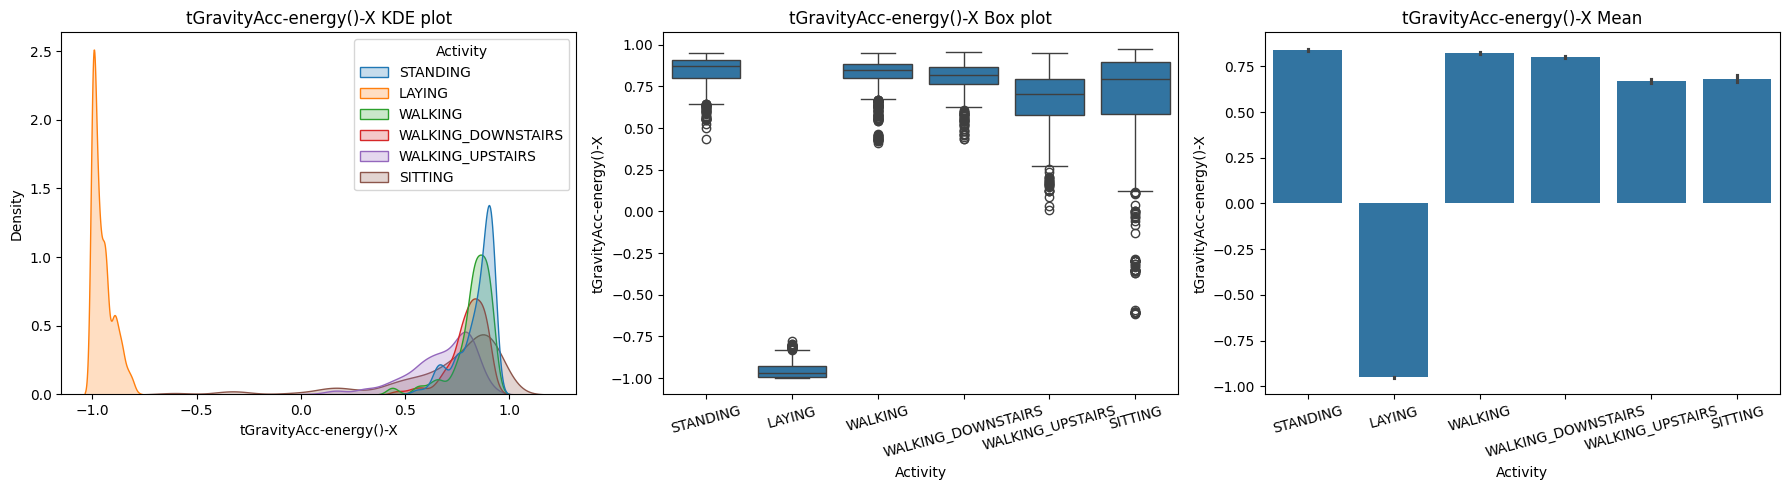

In [50]:
# 3. tGravityAcc-energy()-X
eda(importance_upperfeature_list, 2)

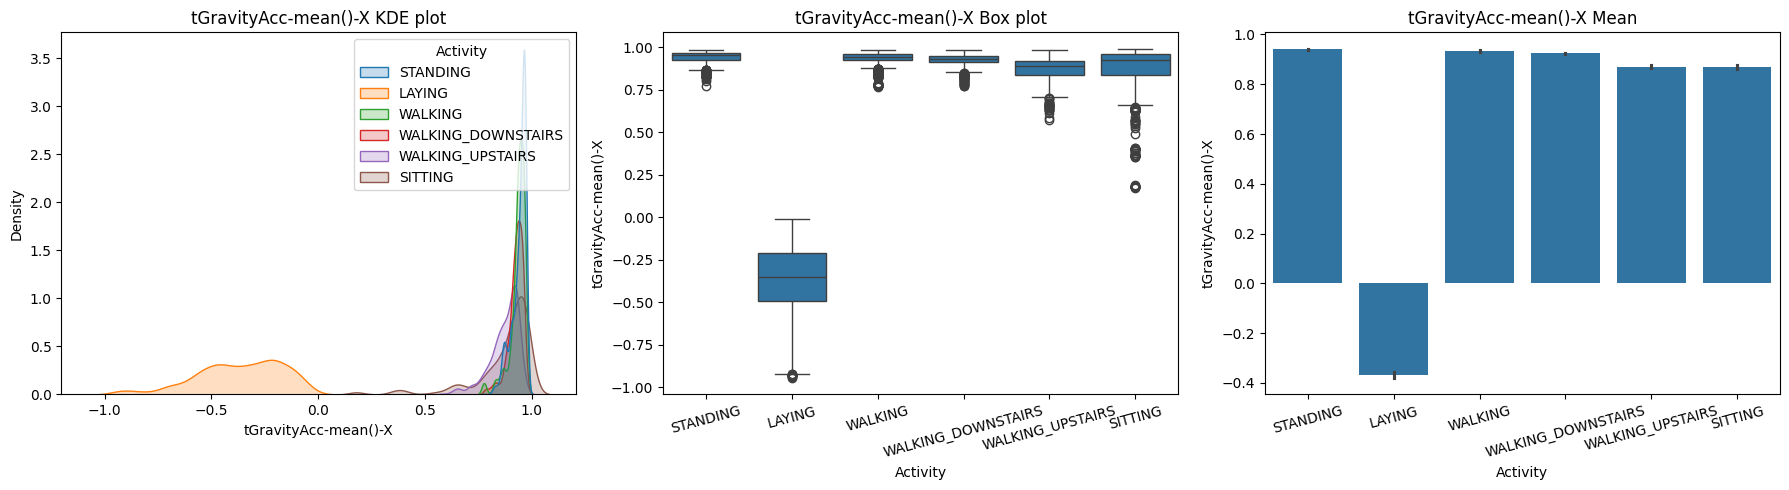

In [51]:
# 4. tGravityAcc-mean()-X
eda(importance_upperfeature_list, 3)

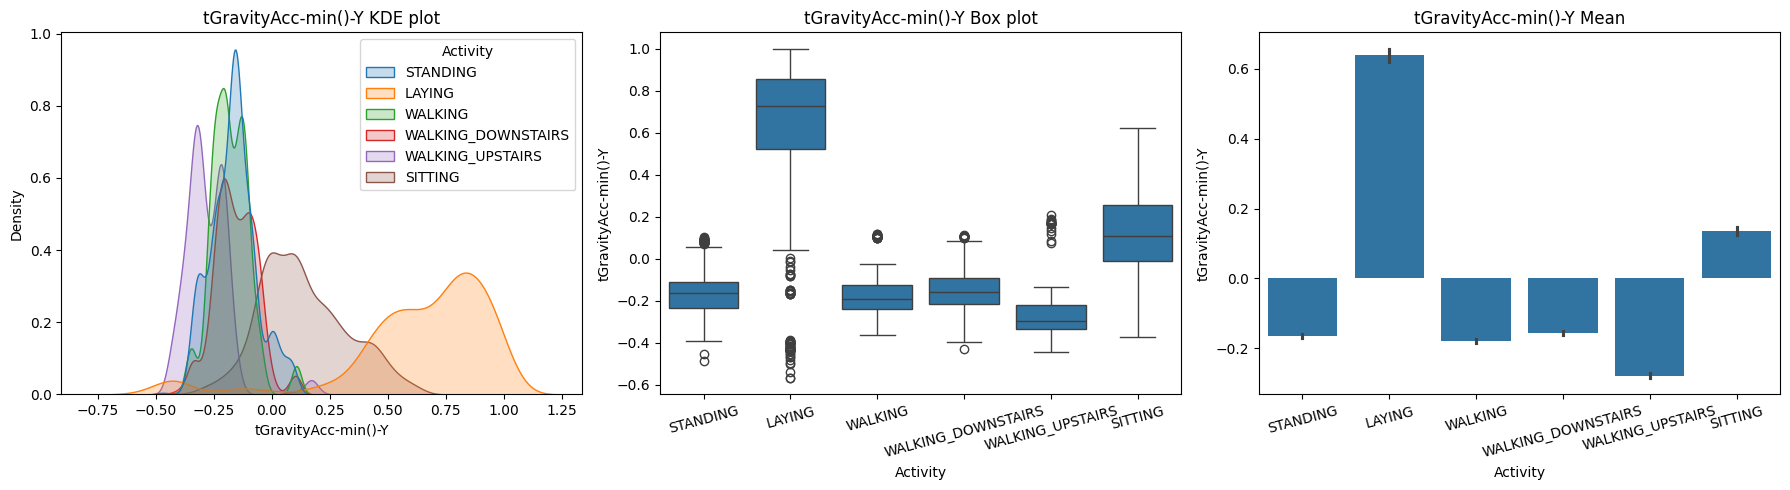

In [52]:
# 5. tGravityAcc-min()-Y
eda(importance_upperfeature_list, 4)

* 전체적으로 눕는 행동은 다른 행동들과 분류가 굉장히 쉽다.
* 마지막중요도를 보면 앉는행동 또한 다른 행동과 조금 구분이되지만 눕기와 겹치는 부분이 발생한다.

In [53]:
n = 5  # 하위 5개만 분석

# 상위 n개 중요도
importance_lowerfeature_list = importance['feature_name'].tail(n).tolist()  # 피처 이름만 추출
importance_lowerfeature_list

['tBodyAccJerk-mean()-X',
 'fBodyBodyGyroJerkMag-sma()',
 'tBodyAcc-mad()-Y',
 'fBodyBodyAccJerkMag-entropy()',
 'fBodyAccJerk-min()-X']

#### 3) 하위 5개 변수에 대한 분석

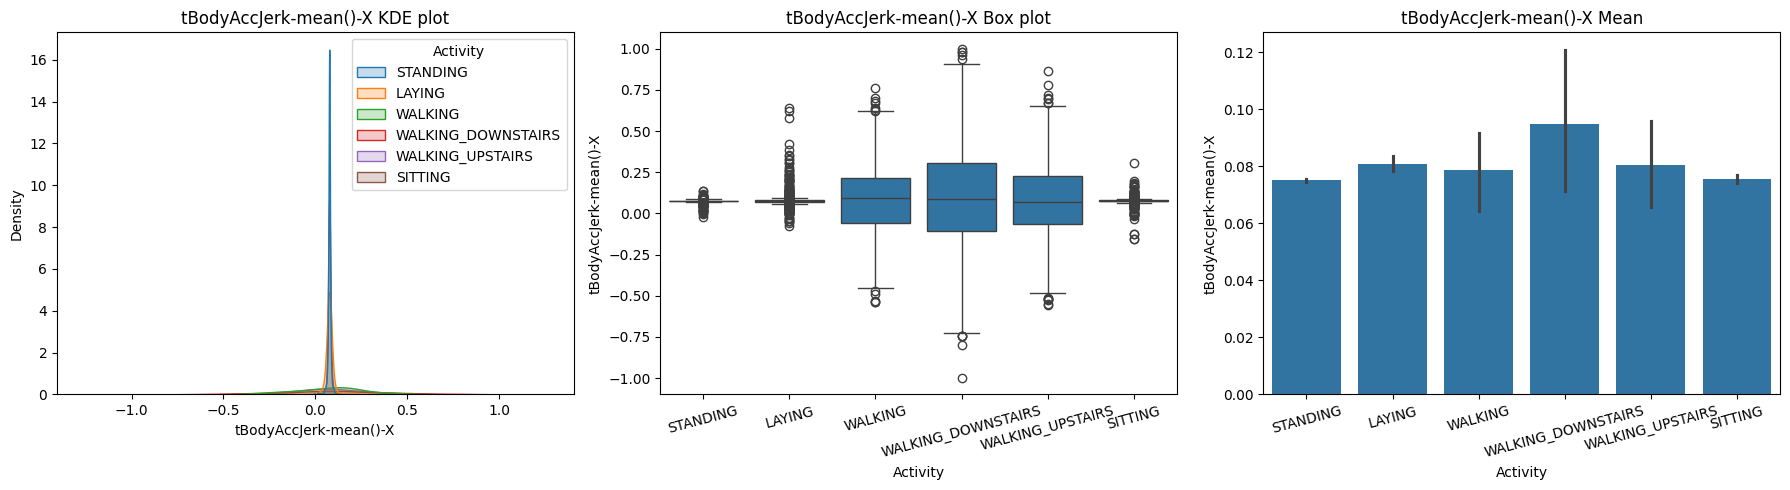

In [54]:
eda(importance_lowerfeature_list, 0)

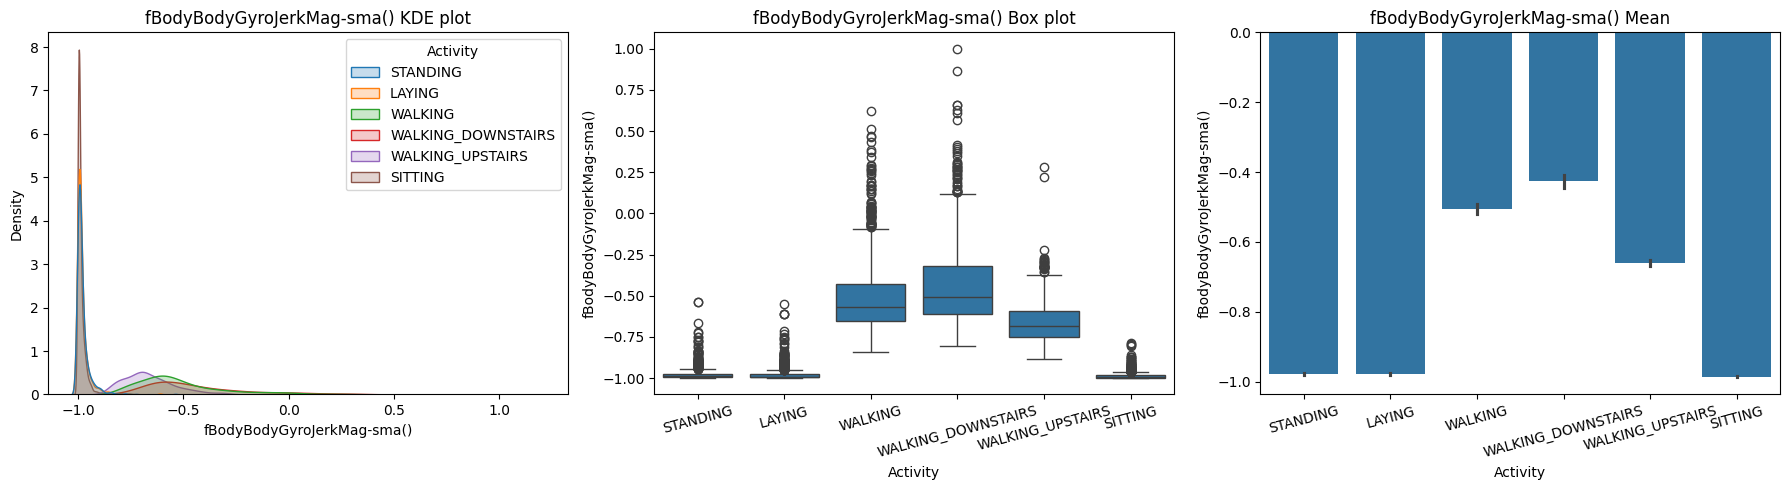

In [55]:
eda(importance_lowerfeature_list, 1)

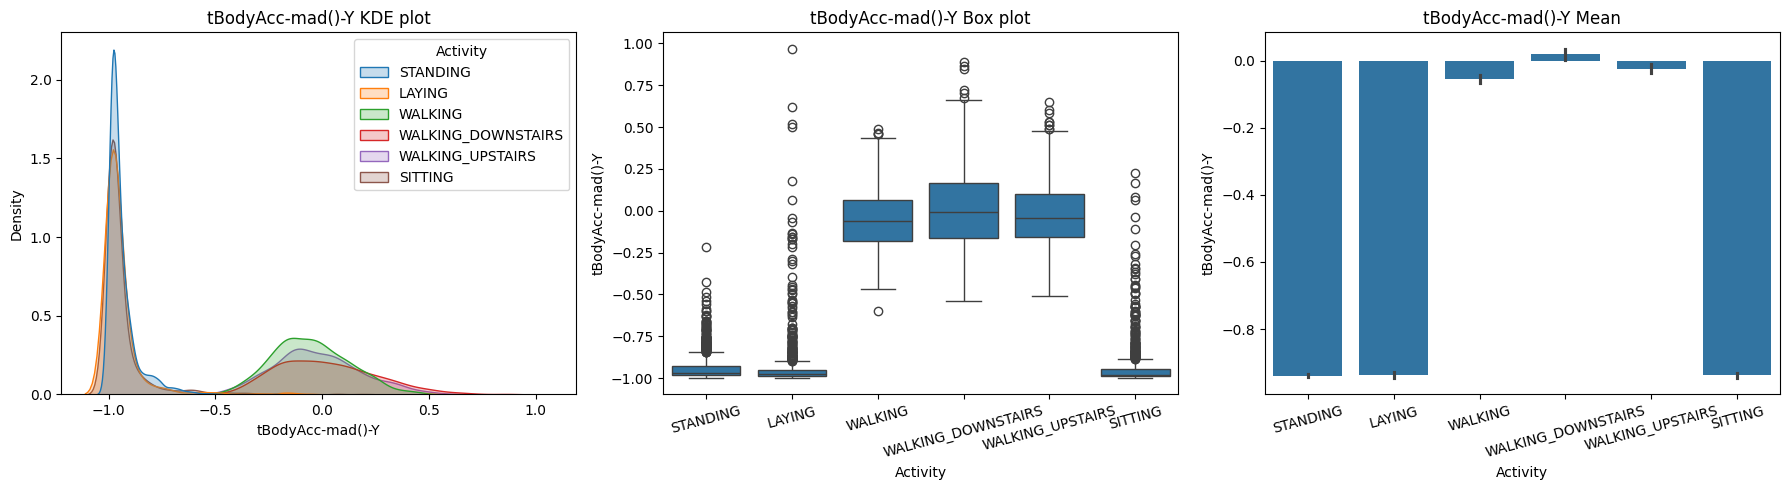

In [56]:
eda(importance_lowerfeature_list, 2)

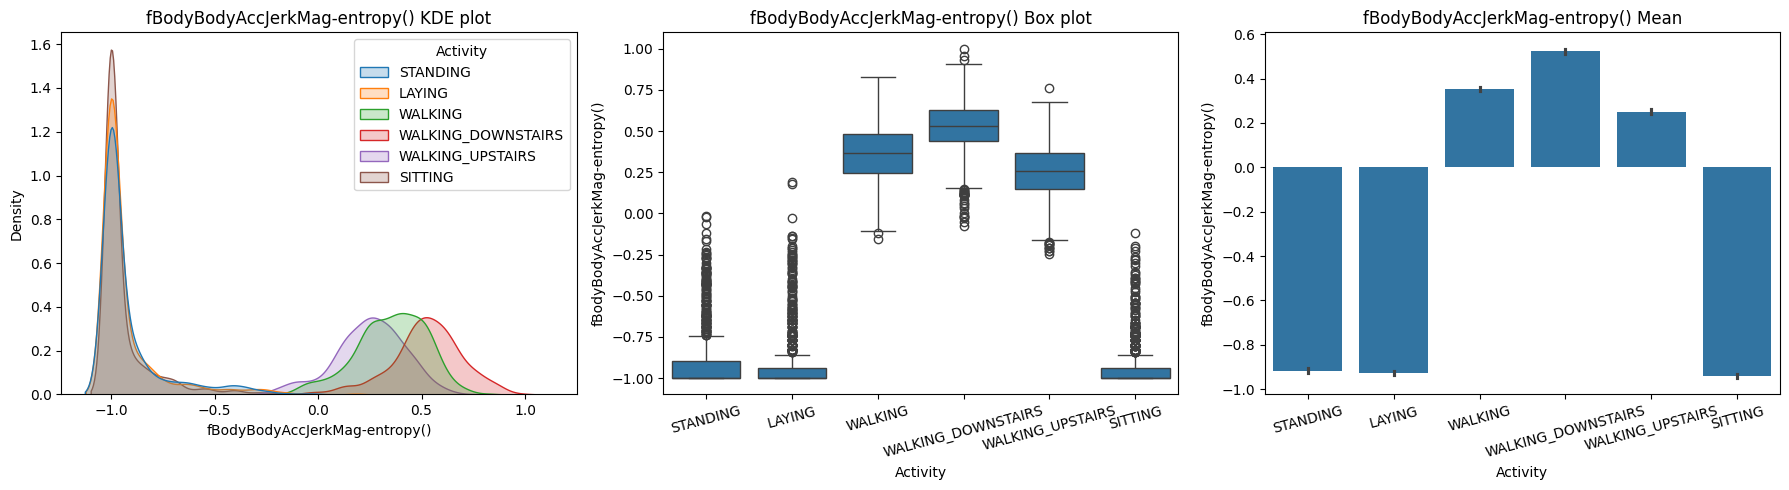

In [57]:
eda(importance_lowerfeature_list, 3)

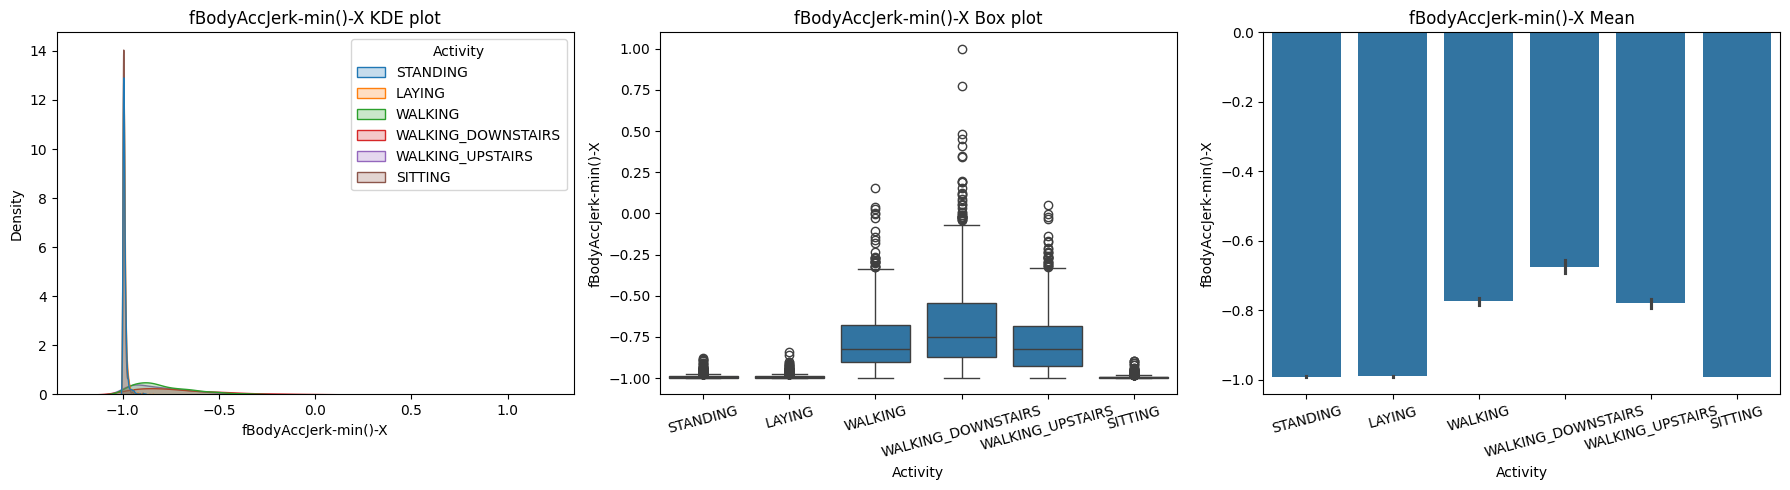

In [58]:
eda(importance_lowerfeature_list, 4)

- 변수중요도 하위5개라 모든 구간이 겹친다. 즉, target값들을 분류를 하려고하는데 필요하지않은 변수라고 생각할 수 있다.

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [59]:
data01_train['is_dynamic'] = np.where(data01_train['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']), 1, 0)

data01_train['is_dynamic'].head()

,is_dynamic
0,0
1,0
2,0
3,1
4,1


In [60]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [61]:
#x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
#기본 모델링

x_train,x_val,y_train,y_val = train_test_split(x, data01_train['is_dynamic'], test_size=0.3, random_state=1)

model_2 = RandomForestClassifier()
model_2.fit(x_train, y_train)
y_pred = model_2.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9988668555240793
[[952   2]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [62]:
importance_dy = plot_feature_importance(model_2.feature_importances_ , x_train.columns, result_only = True, topn = -5)
importance_dy

,feature_name,feature_importance
0,fBodyAccJerk-max()-X,0.050225
1,fBodyAccJerk-energy()-X,0.050029
2,fBodyAccJerk-entropy()-X,0.049912
3,tBodyAccJerk-energy()-X,0.040107
4,fBodyAccJerk-mad()-X,0.039990
...,...,...
551,tGravityAccMag-sma(),0.000000
552,tGravityAccMag-min(),0.000000
553,tGravityAccMag-max(),0.000000
554,tGravityAccMag-mad(),0.000000


In [63]:
zero_count = (importance_dy['feature_importance'] == 0.000000).sum()
zero_count # x(컬럼) = 556개 중 is_dynamic - x(컬럼) 관계없다 => 428개 , 관계있다 =>128개

424

#### 3) 변수중요도 상위 5개 분석

In [66]:
n = 5  # 상위 n개만 분석

# 상위 n개의 중요한 피처 리스트 추출
importance_dy_upperfeature_list = importance_dy['feature_name'].head(n).tolist()  # 피처 이름만 추출
importance_dy_upperfeature_list

['fBodyAccJerk-max()-X',
 'fBodyAccJerk-energy()-X',
 'fBodyAccJerk-entropy()-X',
 'tBodyAccJerk-energy()-X',
 'fBodyAccJerk-mad()-X']

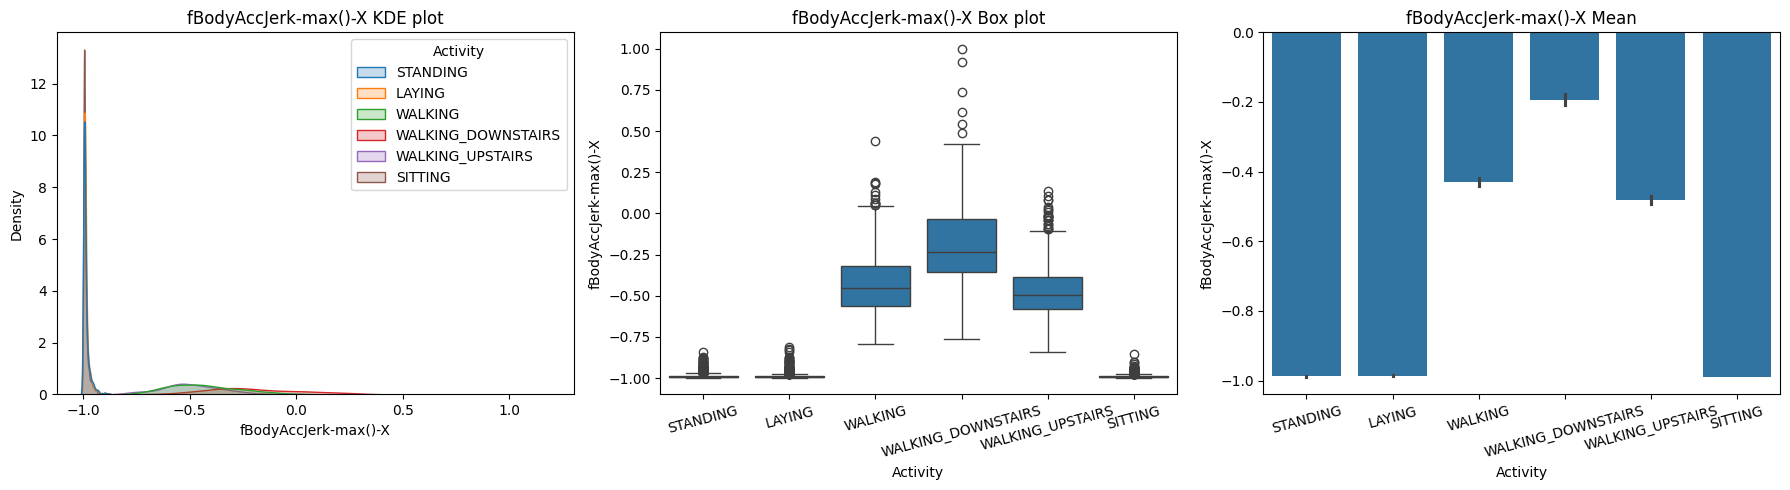

In [67]:
# 'fBodyAccJerk-max()-X'
eda(importance_dy_upperfeature_list, 0)

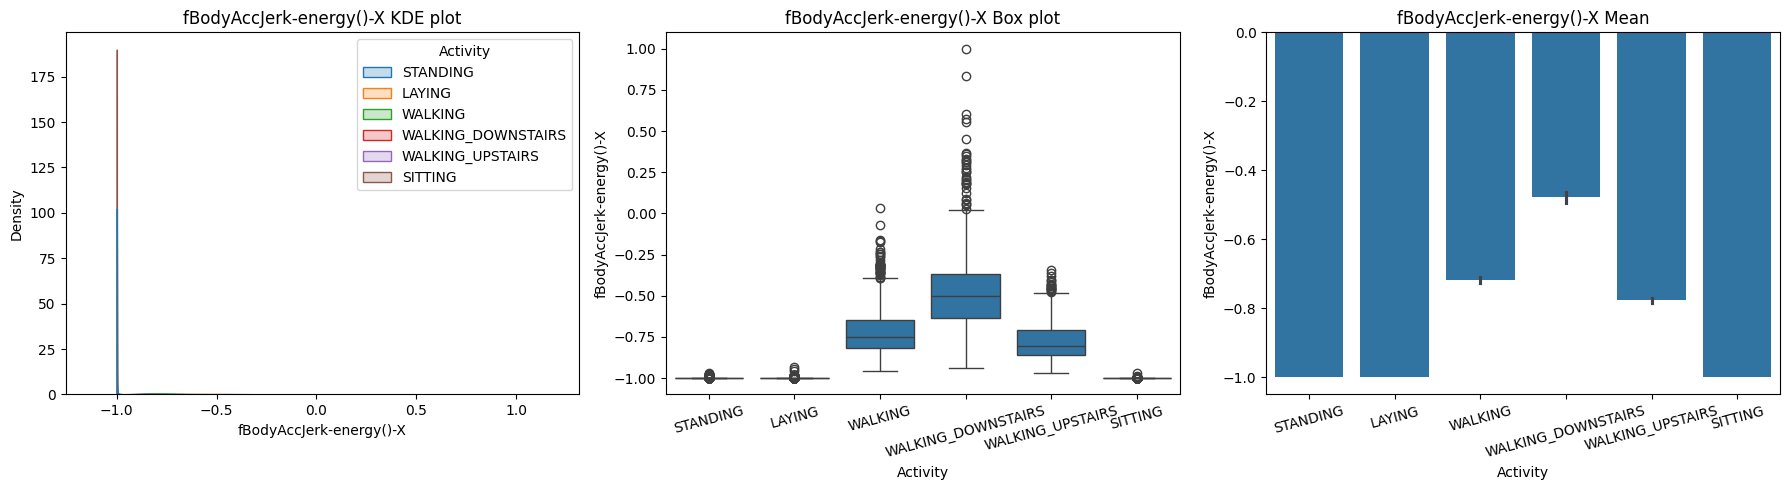

In [68]:
# 'fBodyAccJerk-energy()-X'
eda(importance_dy_upperfeature_list, 1)

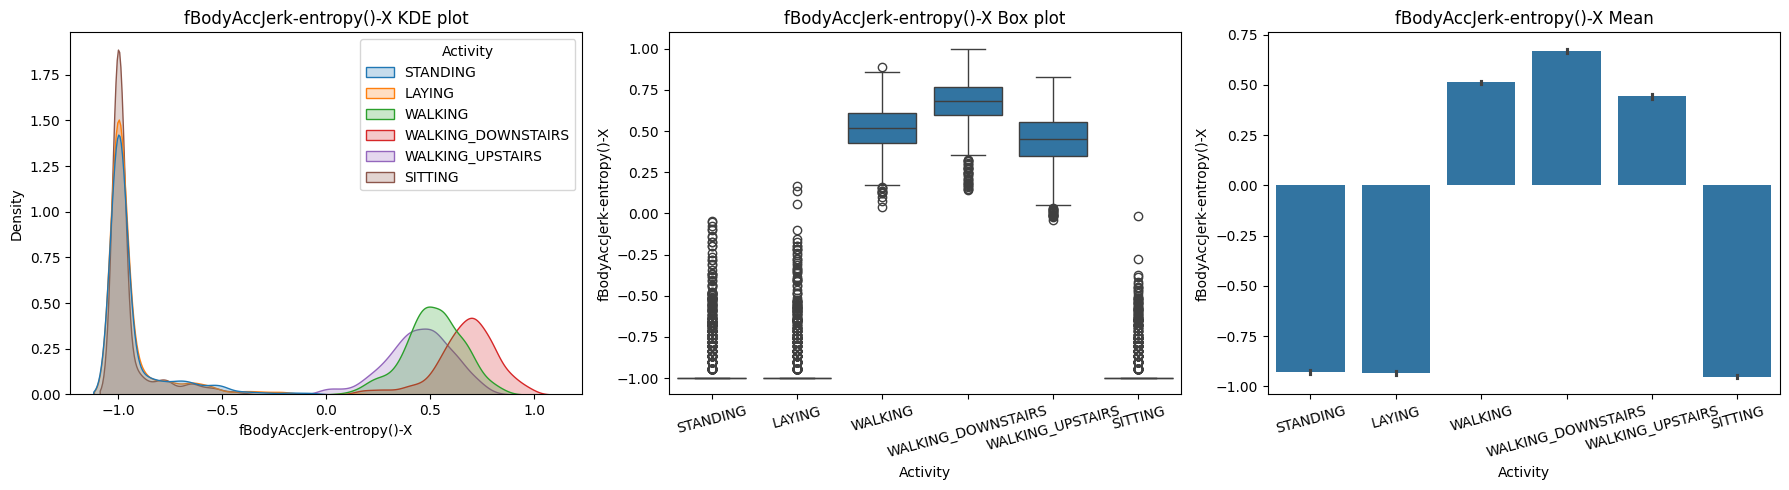

In [69]:
# 'fBodyAccJerk-entropy()-X'
eda(importance_dy_upperfeature_list, 2)

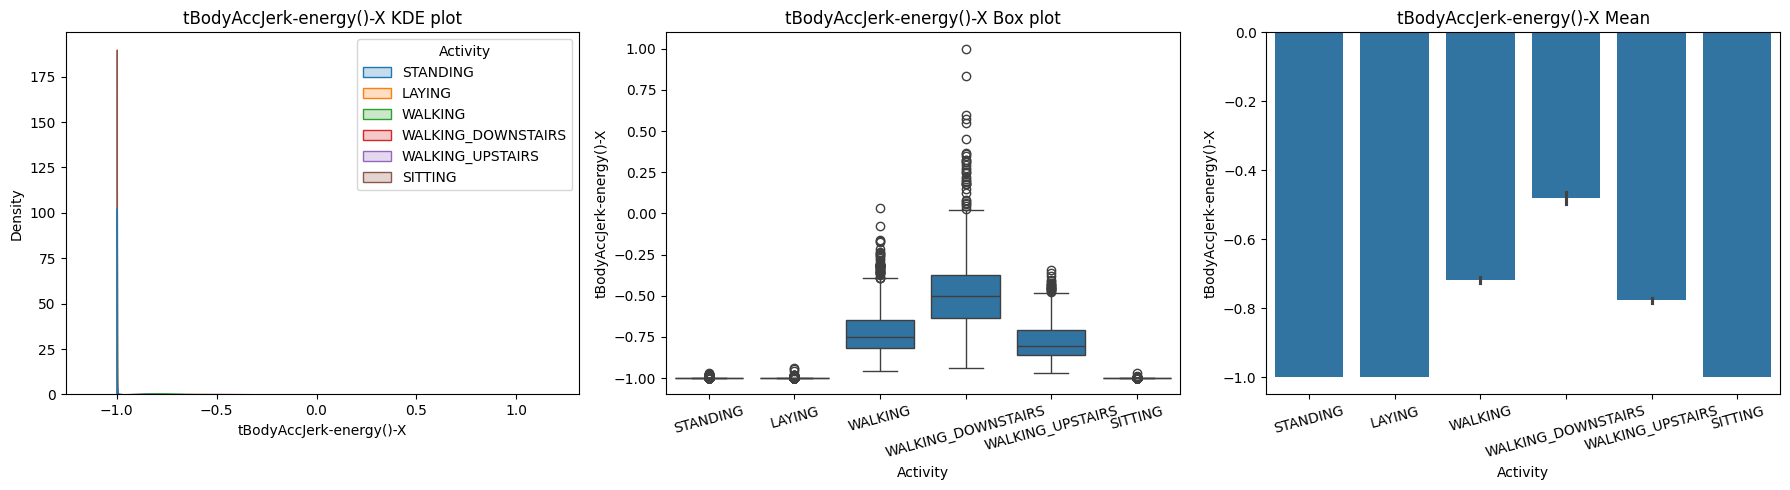

In [70]:
# 'tBodyAccJerk-energy()-X'
eda(importance_dy_upperfeature_list, 3)

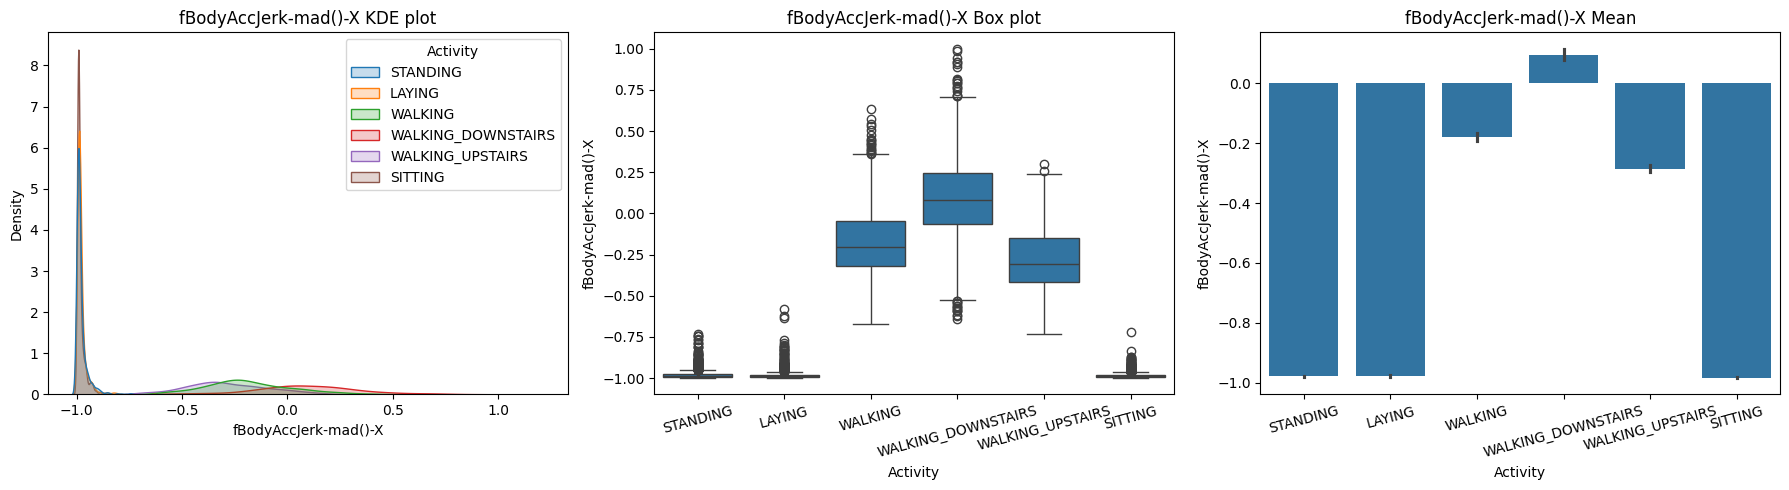

In [71]:
# 'fBodyAccJerk-mad()-X'
eda(importance_dy_upperfeature_list, 4)

- is_dynamic으로 구분해서그런가 전 변수중요도보다 동적,정적행동 구분이 확실하다

## 5.특성 중요도 저장하기 (삭제)

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

#### 2) 합치기

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.